# 1000 Genomes PCA 

## Chris Porras
A notebook to parse 1000 genomes data, convert SNPs to PCA-ble format, and vizualize.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.express as px
%matplotlib inline

In [2]:
# import scikit-allel
import allel

/home/chris/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



### Test if increase memory alloc

In [3]:
import os
import findspark
findspark.init()

import pyspark
import random

memory = '4g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

sc = pyspark.SparkContext(appName="Pi")

ValueError: Couldn't find Spark, make sure SPARK_HOME env is set or Spark is in an expected location (e.g. from homebrew installation).

### Reading 1000 genomes chr21 genotypes

In [3]:
GT = allel.read_vcf('../../data/vcf/ALL.chr21.phase3_shapeit2_mvncall_'
                     +'integrated_v5a.20130502.genotypes.vcf.gz',
                    fields = ['calldata/GT'])

In [12]:
GT = GT['calldata/GT']

In [7]:
ALT = np.load('alternate_seq.npy')

In [8]:
REF = np.load('reference_seq.npy')

In [ ]:
sample_ids = np.load('sample_ids.npy')

### Construct genotype array

In [ ]:
# gt_arr = allel.GenotypeArray(GT)

(array([5.30532465e+09, 2.28747666e+08, 0.00000000e+00, 2.31172700e+06,
        0.00000000e+00, 1.29536000e+05, 1.56790000e+04, 0.00000000e+00,
        4.93300000e+03, 1.10000000e+02]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

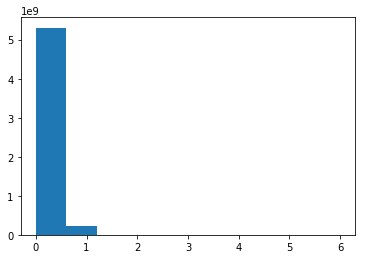

In [14]:
plt.hist(np.ravel(GT))

### Convert binomial SNP coding to monomial with number of variants ( 0 = ref, 1 = var)

In [13]:
GT[GT> 0] = 1

In [14]:
np.save('summarized_genotypes',np.sum(GT,axis=2))

MemoryError: 

### Perform PCA on entire sample

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
######### TAKES FOREVER!! ###########

In [ ]:
pca = PCA(n_components=4)
PCs = pca.fit_transform(conv)

In [ ]:
######################################

#### Projections onto PCs

In [ ]:
PC1 = conv.T@PCs[:,0]

In [ ]:
PC2 = conv.T@PCs[:,1]

In [ ]:
PC3 = conv.T@PCs[:,2]

#### Get sample population location

In [ ]:
key = pd.read_csv("20130606_g1k.ped", sep='\t')

In [ ]:
key.head()

#### Get indeces of rows for our data in the key

In [ ]:
key_id = key.iloc[:,1]
GT_id = callset["samples"]
idx = []
for i in range(len(key_id)):
    for j in range(len(GT_id)):
        if key_id[i] == GT_id[j]:
            idx += i

In [ ]:
pops = key.iloc[idx,6] # populations for our chr21 data

In [ ]:
super_pop = pd.read_csv("20131219.superpopulations.tsv", sep='\t')

In [ ]:
super_pop

In [ ]:
pop_code = pd.read_csv("20131219.populations.tsv", sep='\t')

In [ ]:
# Get indeces of 1000 genomes chr21 samples from key
uni_pops = []
for i in np.unique(pops):
    uni_pops += [np.where(pop_code.iloc[:,1]==i)[0][0]]

In [ ]:
pop_arr = np.array(pops)

In [ ]:
for i in range(len(np.unique(pops))):
    pop_arr[np.where(pops == np.unique(pops)[i])[0]] = np.array(pop_code.iloc[uni_pops,2])[i]

#### Pull out indeces by superpopulation

In [ ]:
AFR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="AFR")[0][0]])[0]
AMR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="AMR")[0][0]])[0]
EAS_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="EAS")[0][0]])[0]
EUR_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="EUR")[0][0]])[0]
SAS_idx= np.where(pop_arr == np.unique(pop_arr)[np.where(np.unique(pop_arr)=="SAS")[0][0]])[0]

#### Vizualize by superpopulation

In [ ]:
pops_col = np.array(pops)

In [ ]:
col_pal = np.arange(len(np.unique(pop_arr)))
for i in col_pal:
    pops_col[np.where(pop_arr == np.unique(pop_arr)[i])[0]] = col_pal[i]

In [ ]:
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(15,15))

ax = plt.axes(projection ='3d')


samples = [AFR_idx,AMR_idx,EAS_idx,EUR_idx,SAS_idx]
colors = np.arange(len(samples))

for samp in samples:
    ax.scatter3D(PC1[samp],PC2[samp],PC3[samp], label = pop_arr[samp][0])
ax.set_xlabel('PC1', fontsize=30)
ax.set_xticks([])
ax.set_ylabel('PC2',fontsize=24)
ax.set_yticks([])
ax.set_zlabel(r'PC3', fontsize=24,rotation = 90)
ax.set_zticks([])
ax.set_title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)
ax.legend(loc =4,prop={'size':20})
fig.savefig("unfiltered_chr21_PCA.jpg",quality=95)

In [ ]:
ax.set_xlabel('PC1', fontsize=30)
ax.set_xticks([])
ax.set_ylabel('PC2',fontsize=24)
ax.set_yticks([])
ax.set_zlabel(r'PC3', fontsize=24,rotation = 90)
ax.set_zticks([])
ax.set_title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)
ax.legend(loc =4,prop={'size':20})
fig.savefig("unfiltered_chr21_PCA.jpg",quality=95)

In [ ]:
plt.figure(figsize=(15,15))
for samp in samples:
    plt.scatter(PC1[samp],PC2[samp], label = pop_arr[samp][0])
plt.xlabel("PC1",fontsize=30,labelpad=20)
plt.xticks([])
plt.ylabel("PC2",fontsize=30,labelpad=20)
plt.yticks([])
plt.legend(loc =4,prop={'size':20})
plt.title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)

plt.savefig("unfiltered_chr21_PC1PC2.jpg",quality=95)

In [ ]:
plt.figure(figsize=(15,15))
for samp in samples:
    plt.scatter(PC2[samp],PC3[samp], label = pop_arr[samp][0])
plt.xlabel("PC2",fontsize=30,labelpad=20)
plt.xticks([])
plt.ylabel("PC3",fontsize=30,labelpad=20)
plt.yticks([])
plt.legend(loc =3,prop={'size':20})
plt.title("1000 Genomes chr21 unfiltered",fontsize=30,pad = 40)

plt.savefig("unfiltered_chr21_PC2PC3.jpg",quality=95)